# Model evaluation: answers

## Step 0: Getting setup

### Imports

In [1]:
# PyTorch framework
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

# Model evaluation
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, auc, roc_curve
import matplotlib.pyplot as plt

# Basic libraries
from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List
import numpy as np
import random
import pathlib
import os
import time
import copy

### Set device

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Exercise 1

# Exercise 1.1: Prepare test_dataset

In [3]:
# Setup testing path
image_path = Path("../datasets/Transport_Dataset")
test_dir = image_path / "test"

In [4]:
# Define the data transform 
test_transform = transforms.Compose([
   transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225]) 
])

# Use ImageFolder to create dataset
test_data = datasets.ImageFolder(
    root = test_dir,
    transform = test_transform  # Transforms to perform on test data (images)
)

# Create the dataloader
test_dataloader = DataLoader(dataset = test_data, 
                             batch_size = 8, 
                             num_workers = 1, 
                             shuffle = True) 

In [5]:
# Get class names as a list
class_names = test_data.classes
print("Class names (list):", class_names)

Class names (list): ['airplanes', 'cars', 'ships']


# Exercise 1.2: Load the trained model

In [6]:
class ClassificationModel(nn.Module):
    def __init__(self, output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*224*224, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [7]:
MODEL_PATH = "../data/models/baseline_model_TransportDataset.pth"
model = ClassificationModel(3).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location = DEVICE))

<All keys matched successfully>

# Exercise 1.3: Obtain model's evaluation metrics

### Inference using the test_dataset

In [8]:
# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
y_true = []
y_pred = []

# Disable gradient computation
with torch.no_grad():
    for test_data in test_dataloader: # Iterate over the test dataloader to get test images and labels
        test_images, test_labels = (test_data[0].to(DEVICE), 
                                    test_data[1].to(DEVICE))
        # Forward pass through the model to get predictions
        output = model(test_images)
        
        # Compute the predicted labels by taking the argmax of the softmax output
        pred_label = torch.softmax(output, dim = 1).argmax(dim = 1)

        # Append the true labels and predicted labels to their respective lists
        y_true.append(test_labels.cpu())
        y_pred.append(pred_label.cpu())

# Convert the lists of true labels and predicted labels to NumPy arrays
y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

### Classification report 

In [9]:
# Generate the classification report and print it
report = classification_report(y_true, 
                               y_pred, 
                               target_names = ["Airplanes","Cars", "Ships"], 
                               digits = 4)
print(report)

              precision    recall  f1-score   support

   Airplanes     0.7485    0.6614    0.7022       189
        Cars     0.8366    0.8756    0.8557       193
       Ships     0.7653    0.8150    0.7893       200

    accuracy                         0.7852       582
   macro avg     0.7835    0.7840    0.7824       582
weighted avg     0.7835    0.7852    0.7831       582



### Confusion matrix (normalized)
In this scenario, we perform normalization with respect to the actual values by normalizing each row. This process ensures that the sum of all columns in each row equals 1. 

Try replacing:

`normalize = 'true'` with either

`normalize = 'all'` or `normalize = 'pred'`

and analize the results

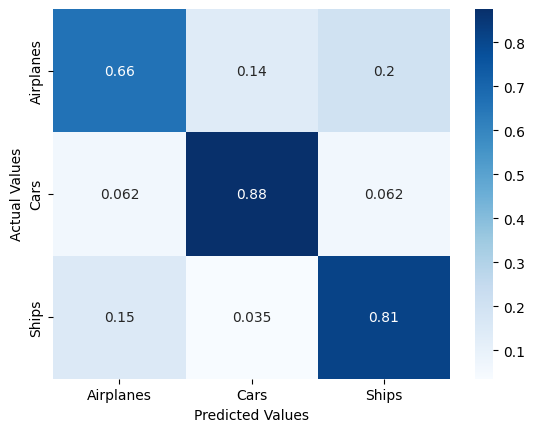

In [10]:
# Generate the confusion matrix
cmat = confusion_matrix(y_true, y_pred, normalize = 'true')

# Create a heatmap for the confusion matrix visualization
ax = sns.heatmap(cmat, annot = True, cmap = 'Blues')

# Set labels for x-axis and y-axis
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Set the labels 
ax.xaxis.set_ticklabels(["Airplanes","Cars", "Ships"])
ax.yaxis.set_ticklabels(["Airplanes","Cars", "Ships"])

# Display the visualization of the Confusion Matrix
plt.show()

# Exercise 1.4: Visualize model predictions and target labels

In [11]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [12]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}| True label: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode = was_training)

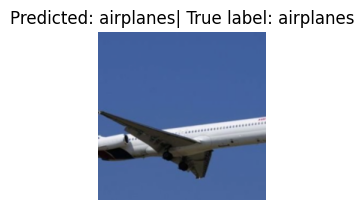

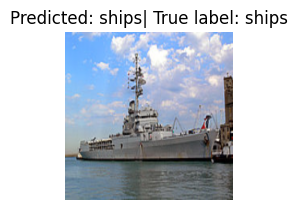

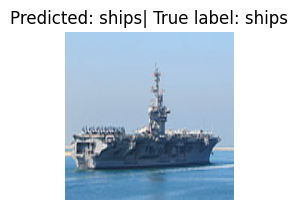

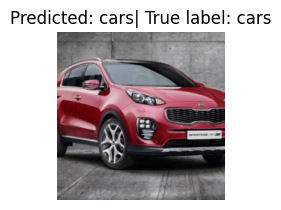

In [13]:
visualize_model(model, num_images = 4)

# EXERCISE 2:

In [14]:
# Data
labels = [0,1,0,0,1,1,1,0,1,0,0,0,1,0,1,1,0,1,1,1,1]
predictions = [0,0,0,0,1,1,1,0,1,0,0,1,1,0,1,1,1,0,1,1,0]
outputs = [0.34,0.49,0.12,0.23,0.67,0.92,0.85,0.46,0.73,0,0,1,1,0.42,0.61,0.53,0.55,0.35,0.58,0.66,0.33]

### 2.1 Determine the true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN)

In [15]:
# Generate the confusion matrix
tn, fp, fn, tp  = confusion_matrix(labels, predictions).ravel()

# Print the results
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("True Positives (TP):", tp)

True Negatives (TN): 7
False Positives (FP): 2
False Negatives (FN): 3
True Positives (TP): 9


### 2.2 Use the values from the confusion matrix to compute the accuracy, recall, precision, specificity, and F1-Score. Treat the class labeled as (1) as the positive and the one labeled as (0) as the negative. Compare these results with the ones obtained using the *classification_report* function  and the specific functions for each metric (recall, precision, f1-score and accuracy).

In [16]:
# Generate the classification report and print it
report = classification_report(labels, 
                               predictions, 
                               target_names = ["Class A","Class B"], 
                               digits = 4)
print(report)

              precision    recall  f1-score   support

     Class A     0.7000    0.7778    0.7368         9
     Class B     0.8182    0.7500    0.7826        12

    accuracy                         0.7619        21
   macro avg     0.7591    0.7639    0.7597        21
weighted avg     0.7675    0.7619    0.7630        21



Using the formulas provided on slide 9 of the pdf "Evaluation methods" we have:

In [17]:
# Calculate the metrics manually
accuracy = (tp + tn) / (tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = 2 * precision * recall / (precision + recall)

# Print the results
print("Metrics calculated from confusion_matrix results:tn, fp, fn, tp ")
print("---------------------------------------")
print("Accuracy =", accuracy)
print("Precision =", precision)
print("Recall =", recall)
print("Specificity =", specificity)
print("F1_Score =", f1_score)

# Calculate recall, precision, F1-score and accuracy using specific functions
accuracy = sklearn.metrics.accuracy_score(labels, predictions)
precision = sklearn.metrics.precision_score(labels, predictions)
recall = sklearn.metrics.recall_score(labels, predictions)
f1_score = sklearn.metrics.f1_score(labels, predictions)

# Print the results
print()
print("Metrics obtained using sklearn.metrics")
print("---------------------------------------")
print("Accuracy =", accuracy)
print("Precision =", precision)
print("Recall =", recall)
print("F1_Score =", f1_score)

Metrics calculated from confusion_matrix results:tn, fp, fn, tp 
---------------------------------------
Accuracy = 0.7619047619047619
Precision = 0.8181818181818182
Recall = 0.75
Specificity = 0.7777777777777778
F1_Score = 0.7826086956521738

Metrics obtained using sklearn.metrics
---------------------------------------
Accuracy = 0.7619047619047619
Precision = 0.8181818181818182
Recall = 0.75
F1_Score = 0.7826086956521738


### 2.3  Analyze the table generated with the classification report method. Determine the specificity from it. Explain how you can do it. Also, explain the meaning of "macro avg" and "weighted avg."

While the table doesn't explicitly display specificity, we can observe that its value corresponds to the recall of the class designated as negative (class A in our example). This can be readily comprehended by comparing the formulas for sensitivity (recall) and specificity for a binary classification problem.

> **macro avg**:  It calculates the average of the metrics (precision, recall, F1-score) for each class independently and then takes the unweighted mean across all classes. In other words, it treats all classes equally, regardless of their size or imbalance in the dataset.

> **weighted avg**: It also calculates the average of the metrics for each class independently, but it takes the weighted mean across all classes based on their support (the number of samples for each class). In this case, the contribution of each class to the average is weighted by the number of samples in that class. 

**macro avg** and **weighted avg** will give the same result when we have the same number of samples per class.

### 2.4  Obtain the ROC curve and AUC (Area Under the Curve) using the provided model probabilities. In this case, when p>0.5, the prediction is 1, and when p<0.5, the prediction is 0

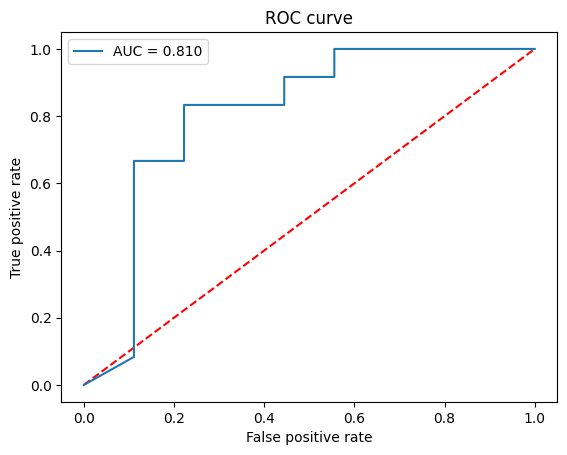

In [18]:
roc_auc_score(labels,outputs)
false_positive_rate, true_positive_rate, threshold = roc_curve(labels, outputs)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc = 'best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

> Note: If we increase the number of samples, the graph will exhibit a smoother shape